# Load MNIST data set

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
import numpy as np

X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)

print(X.shape)

(70000, 784)


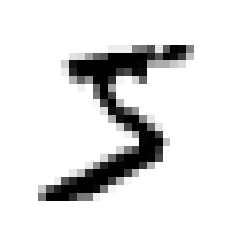

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
X_train, X_test, y_train, y_test = X[:6000], X[6000:], y[:6000], y[6000:]

# Training a binary classifier

Train a classifier to train by two classes: 5 and not 5.

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

sgd_clf = SGDClassifier(random_state=42)
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.962 , 0.956 , 0.9665])

In [7]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91 , 0.915, 0.918])

Above example shows why accuracy is not the best measure for a classifier, especially w/ a skewed dataset.

# Confusion Matrix

In [8]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [9]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[5375,  111],
       [ 120,  394]])

In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))
print(f1_score(y_train_5, y_train_pred))  # F1 is a combo measure of precision and recall

0.7801980198019802
0.7665369649805448
0.7733071638861628


In [11]:
from sklearn.metrics import roc_curve

# Use `decision_function` so that we can get a sense of the precision/recall tradeoff
# Default value for `method` is `predict`.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

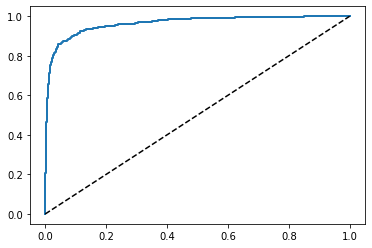

In [12]:
def plot_roc_curve(fpr, tpr, label=None):
    # The farther up and to the left, the better
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [13]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)  # 1 is perfect, .5 is what random achieves

0.9641599203348885

In [14]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [15]:
y_scores_forest = y_probas_forest[:, 1]  # proba of a positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

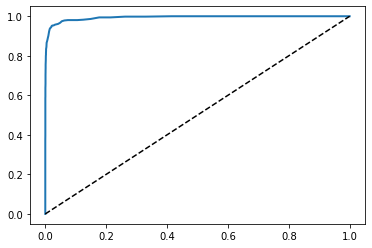

In [16]:
plot_roc_curve(fpr_forest, tpr_forest)

In [17]:
roc_auc_score(y_train_5, y_scores_forest)

0.9936162229715256

# Multiclass classification

In [18]:
from sklearn.svm import SVC

# Scikit is able to automatically support mutli-class for SVM, even though support-vector machines
# are strictly binary classifiers. Does one-versus-the-rest (or one-versus-one) under the hood

svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC()

In [20]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [21]:
sgd_clf = SGDClassifier(random_state=42)
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8565, 0.8715, 0.8635])

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=3)
cross_val_score(rf_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.929 , 0.9415, 0.9275])

In [26]:
param_grid = [
    {"n_estimators": [3, 10, 100, 200], "max_features": [2, "auto", "log2"]}
]

from sklearn.model_selection import GridSearchCV

# Experiment w/ different hyperparameters using a GridSearchCV
grid_search = GridSearchCV(
    rf_clf, param_grid, cv=5, scoring="accuracy", return_train_score=True
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=3),
             param_grid=[{'max_features': [2, 'auto', 'log2'],
                          'n_estimators': [3, 10, 100, 200]}],
             return_train_score=True, scoring='accuracy')

In [27]:
grid_search.best_params_

{'max_features': 'log2', 'n_estimators': 200}

In [28]:
grid_search.cv_results_

{'mean_fit_time': array([0.04205933, 0.08716602, 0.62076483, 1.1569067 , 0.08808069,
        0.23543973, 1.99797673, 3.72351198, 0.0504251 , 0.11748028,
        0.97018361, 1.98158083]),
 'std_fit_time': array([0.00121222, 0.00205189, 0.01383017, 0.01714957, 0.00185   ,
        0.00469505, 0.04547073, 0.05017589, 0.00150589, 0.00078399,
        0.00208447, 0.07734727]),
 'mean_score_time': array([0.00471358, 0.00750184, 0.04855061, 0.09031258, 0.003825  ,
        0.00654206, 0.03333941, 0.05830131, 0.00395899, 0.00648289,
        0.03698115, 0.07737317]),
 'std_score_time': array([0.00025729, 0.00030497, 0.00163455, 0.00187385, 0.00017603,
        0.00040002, 0.00166224, 0.0004793 , 0.00025638, 0.00016857,
        0.00101711, 0.00675502]),
 'param_max_features': masked_array(data=[2, 2, 2, 2, 'auto', 'auto', 'auto', 'auto', 'log2',
                    'log2', 'log2', 'log2'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, F

In [32]:
# Overfit
grid_search.best_estimator_.score(X_test, y_test)

0.93921875